In [1]:
# --- Environment Setup ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Running on:", device)

Running on: mps


In [258]:

# --- Bayesian Linear Layer ---
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.mu_weight = nn.Parameter(torch.Tensor(out_features, in_features).normal_(0, 0.1))
        self.rho_weight = nn.Parameter(torch.Tensor(out_features, in_features).fill_(-5))
        self.mu_bias = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.1))
        self.rho_bias = nn.Parameter(torch.Tensor(out_features).fill_(-5))

    def forward(self, x):
        std_weight = torch.log1p(torch.exp(self.rho_weight))  # softplus-ish
        std_bias   = torch.log1p(torch.exp(self.rho_bias))

        eps_w = torch.randn_like(std_weight)
        eps_b = torch.randn_like(std_bias)

        sampled_weight = self.mu_weight + std_weight * eps_w
        sampled_bias   = self.mu_bias + std_bias * eps_b

        kl = self.kl_divergence(self.mu_weight, self.mu_bias, std_weight, std_bias)
        return F.linear(x, sampled_weight, sampled_bias), kl

    def kl_divergence(self, mu_w, mu_b, std_w, std_b):
        var_w = std_w ** 2
        var_b = std_b ** 2

        kl_w = 0.5 * (var_w + mu_w ** 2 - 1 - var_w.log())
        kl_b = 0.5 * (var_b + mu_b ** 2 - 1 - var_b.log())

        total_params = mu_w.numel() + mu_b.numel()
        return (kl_w.sum() + kl_b.sum()) / total_params

# --- B-PINN Model for SRMHD ---
class BayesianPINN(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, output_dim=6, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList()

        self.layers.append(BayesianLinear(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(BayesianLinear(hidden_dim, hidden_dim))
        self.layers.append(BayesianLinear(hidden_dim, output_dim))

    def forward(self, x):
        kl_total = 0.0
        for layer in self.layers[:-1]:
            x, kl = layer(x)
            x = torch.relu(x)
            kl_total += kl
        x, kl = self.layers[-1](x)
        kl_total += kl

        log_rho = x[:, 0:1]
        log_p   = x[:, 1:2]
        rho = torch.pow(10.0, log_rho.clamp(min=-15, max=15))
        p   = torch.pow(10.0, log_p.clamp(min=-15, max=15))
        s       = torch.sigmoid(x[:, 2:3]) * 0.99
        u       = F.normalize(x[:, 3:6], dim=1)
        v       = s * u
        return torch.cat([rho, p, v], dim=1), kl_total

def prim_to_con(rho, p, v, B, gamma=5.0/3.0):
    """
    Convert primitive variables to conserved ones.

    Args:
        rho: rest-mass density, shape (N, 1)
        p: pressure, shape (N, 1)
        v: velocity, shape (N, 3)
        B: magnetic field, shape (N, 3)
        gamma: adiabatic index

    Returns:
        D, S, tau — all (N, 1)/(N, 3) tensors
    """
    v2 = (v ** 2).sum(dim=1, keepdim=True)
    W = 1.0 / torch.sqrt(1.0 - v2 + 1e-10)
    h = 1.0 + (gamma / (gamma - 1.0)) * (p / rho)

    B2 = (B ** 2).sum(dim=1, keepdim=True)
    B_dot_v = (B * v).sum(dim=1, keepdim=True)

    # Energy
    U = rho * h * W**2 - p + 0.5 * (B2 * (1 + v2) - B_dot_v**2)
    D = rho * W
    tau = U - D

    # Momentum
    S = (rho * h) * W**2 * v + B2 * v - B_dot_v * B

    return D, S, tau, v2, v, B2, W

def sample_magnetic_field(N, rho, sigma_range=(1e-3, 1)):
    """
    Sample magnetic field vectors with |B| = sqrt(sigma * rho)
    """
    log_sigma = torch.rand(N, 1) * (torch.log10(torch.tensor(sigma_range[1])) - torch.log10(torch.tensor(sigma_range[0]))) + torch.log10(torch.tensor(sigma_range[0]))
    sigma = 10 ** log_sigma  # log-uniform sigma
    
    B_dir = torch.randn(N, 3)
    B_dir = F.normalize(B_dir, dim=1)
    B_mag = torch.sqrt(sigma * rho)  # shape (N, 1)

    B = B_dir * B_mag
    return B, sigma

def generate_physical_data(N):
    log_rho = torch.rand(N, 1) * 3 - 3       # log10(ρ) ∈ [-5, 1]
    rho = 10**log_rho

    q = 10**(torch.rand(N, 1) * 3 - 2)       # log10(q) ∈ [-2, 2]
    p = rho * q
    
    v_dir = torch.randn(N, 3)
    v_dir = F.normalize(v_dir, dim=1)
    s     = torch.rand(N, 1) * 0.9           # ensure v² < 1
    v     = s * v_dir

    B, sigma = sample_magnetic_field(N, rho)

    D, S, tau, _, _, _, _ = prim_to_con(rho, p, v, B)
    cons_input = torch.cat([D, S, tau, B], dim=1)
    return cons_input, torch.cat([rho, p, v], dim=1)

# --- Training Loop for Bayesian PINN ---
def train_model_bayesian(hidden_dim=256, num_layers=5, lr=1e-3, epochs=2000, batch_size=1000, beta=1e-4, verbose=True):
    model = BayesianPINN(input_dim=8, hidden_dim=hidden_dim, output_dim=6, num_layers=num_layers)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.95,
        min_lr=1e-6,
        verbose=False
    )
    
    N = 200_000
    train_data, prim_data = generate_physical_data(N)
    
    print("Ranges of conserved quantities:")
    print(f"D     ∈ [{train_data[:,0].min():.2e}, {train_data[:,0].max():.2e}]")
    print(f"S_i   ∈ [{train_data[:,1:4].min():.2e}, {train_data[:,1:4].max():.2e}]")
    print(f"τ     ∈ [{train_data[:,4].min():.2e}, {train_data[:,4].max():.2e}]")
    print(f"B_i   ∈ [{train_data[:,5:8].min():.2e}, {train_data[:,5:8].max():.2e}]")
    
    num_batches = (N + batch_size - 1) // batch_size
    loss_history = []

    if verbose:
        print(f"Training Bayesian PINN with beta={beta}")
        print(f"Batch size = {batch_size}, Num batches = {num_batches}")

    for epoch in range(epochs):
        perm = torch.randperm(N)
        
        epoch_loss = 0.0
        epoch_model_loss = 0.0
        epoch_kl_loss = 0.0
        
        effective_beta = beta *(min(1.0, (epoch - 200) / 200))**2 if epoch > 200 else 0
        
        for i in range(0, N, batch_size):
            optimizer.zero_grad()
            idx = perm[i:i + batch_size]
            batch = train_data[idx]
            pred, kl = model(batch)

            rho_pred   = pred[:, 0:1]
            p_pred     = pred[:, 1:2]
            v_pred     = pred[:, 2:5]

            rho   = prim_data[idx][:, 0:1]
            p     = prim_data[idx][:, 1:2]
            v     = prim_data[idx][:, 2:5]

            
            loss_rho   = (rho-rho_pred).pow(2).mean()
            loss_v   = (v-v_pred).pow(2).mean()
            loss_p = (p-p_pred).pow(2).mean()
            
            model_loss = loss_rho + loss_v + loss_p  #+ loss_v # + penalty_D + penalty_tau + penalty_vsq
            kl_loss = effective_beta * kl
            loss = model_loss + kl_loss
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=50.0)
            optimizer.step()
            
            epoch_kl_loss += kl_loss.item()
            epoch_model_loss+= model_loss.item()
            epoch_loss += loss.item()
        if(epoch > 200):
            scheduler.step(epoch_loss)
        
        epoch_loss /= num_batches
        epoch_model_loss /= num_batches
        epoch_kl_loss /= num_batches
        loss_history.append([epoch_loss,epoch_model_loss,epoch_kl_loss])
        
        current_lr = optimizer.param_groups[0]['lr']
        
        if verbose and epoch % 10 == 0:
            print(f"Epoch {epoch:4d} | Total Loss: {epoch_loss:.4f} | Model: {epoch_model_loss:.4e} | KL: {epoch_kl_loss:.4e} | Eff Beta {effective_beta:.4e} | LR: {current_lr:.2e}")

    return {
        "model": model,
        "loss_history": loss_history,
        "final_loss": epoch_loss,
    }

def evaluate_model(model, input_tensor, n_samples=100):
    """
    Perform MC sampling at inference time.
    
    Args:
        model: Trained BayesianPINN model
        input_tensor: Tensor of shape (N, 8)
        n_samples: Number of MC samples

    Returns:
        Tuple of (mean_prediction, std_prediction) of shape (N, 5)
    """
    model.eval()
    preds = []

    with torch.no_grad():
        for _ in range(n_samples):
            pred, _ = model(input_tensor)
            preds.append(pred.unsqueeze(0))  # shape: (1, N, 5)

    preds = torch.cat(preds, dim=0)  # shape: (n_samples, N, 5)
    mean_pred = preds.mean(dim=0)   # shape: (N, 5)
    std_pred  = preds.std(dim=0)    # shape: (N, 5)

    return mean_pred, std_pred

In [259]:
logs = train_model_bayesian()

Ranges of conserved quantities:
D     ∈ [1.00e-03, 2.25e+00]
S_i   ∈ [-7.92e+01, 6.89e+01]
τ     ∈ [1.83e-05, 9.88e+01]
B_i   ∈ [-9.36e-01, 9.47e-01]
Training Bayesian PINN with beta=0.0001
Batch size = 1000, Num batches = 200
Epoch    0 | Total Loss: 357821370985.8220 | Model: 3.5782e+11 | KL: 0.0000e+00 | Eff Beta 0.0000e+00 | LR: 1.00e-03
Epoch   10 | Total Loss: 117.3119 | Model: 1.1731e+02 | KL: 0.0000e+00 | Eff Beta 0.0000e+00 | LR: 1.00e-03
Epoch   20 | Total Loss: 0.0325 | Model: 3.2505e-02 | KL: 0.0000e+00 | Eff Beta 0.0000e+00 | LR: 1.00e-03
Epoch   30 | Total Loss: 0.0244 | Model: 2.4371e-02 | KL: 0.0000e+00 | Eff Beta 0.0000e+00 | LR: 1.00e-03
Epoch   40 | Total Loss: 0.0211 | Model: 2.1096e-02 | KL: 0.0000e+00 | Eff Beta 0.0000e+00 | LR: 1.00e-03
Epoch   50 | Total Loss: 0.0157 | Model: 1.5737e-02 | KL: 0.0000e+00 | Eff Beta 0.0000e+00 | LR: 1.00e-03
Epoch   60 | Total Loss: 0.0133 | Model: 1.3283e-02 | KL: 0.0000e+00 | Eff Beta 0.0000e+00 | LR: 1.00e-03
Epoch   70 | Total

In [260]:
# --- Validation Set Creation ---
N_val = 15_000
val_cons, val_prim = generate_physical_data(N_val)

mean, std = evaluate_model(logs["model"], val_cons, n_samples=100)


In [261]:
def plot_hist_single(ax_mean, ax_std, mean_values, true_values, std_values, label):
    """Plot histogram of prediction error and predicted uncertainty (std)."""
    errors = mean_values - true_values

    ax_mean.hist(errors, bins=50, alpha=0.7, label=f"{label} mean error")
    ax_mean.set_title(f"Error Distribution ({label})")
    ax_mean.set_xlabel("Prediction Error")
    ax_mean.set_ylabel("Frequency")
    ax_mean.grid(True)
    ax_mean.legend()

    ax_std.hist(std_values, bins=50, alpha=0.7, color='orange', label=f"{label} std")
    ax_std.set_title(f"Predicted Std Distribution ({label})")
    ax_std.set_xlabel("Predicted Std")
    ax_std.set_ylabel("Frequency")
    ax_std.grid(True)
    ax_std.legend()


def plot_scatter_single(ax, val_true, val_pred, val_std, label):
    """Scatter plot: true vs predicted with color indicating uncertainty."""
    sc = ax.scatter(val_true, val_pred, c=val_std, cmap="viridis", s=10)
    ax.set_title(f"Predicted vs True ({label})")
    ax.set_xlabel(f"True {label}")
    ax.set_ylabel(f"Predicted {label}")
    ax.set_xlim(min(val_true),max(val_true))
    ax.set_ylim(min(val_true),max(val_true))


    ax.grid(True)
    return sc  


def plot_binned_uncertainty(ax, x_vals, mean_vals, std_vals, label="ρ", bins=100):
    # Bin x
    bin_edges = np.linspace(x_vals.min(), x_vals.max(), bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    mean_binned = np.zeros(bins)
    std_binned = np.zeros(bins)

    for i in range(bins):
        mask = (x_vals >= bin_edges[i]) & (x_vals < bin_edges[i+1])
        if mask.sum() > 0:
            mean_binned[i] = mean_vals[mask].mean()
            std_binned[i] = std_vals[mask].mean()
        else:
            mean_binned[i] = np.nan
            std_binned[i] = np.nan

    ax.plot(bin_centers, mean_binned, label=f"Mean prediction ({label})")
    ax.fill_between(
        bin_centers,
        mean_binned - std_binned,
        mean_binned + std_binned,
        alpha=0.3,
        label="±1 std"
    )
    ax.set_title(f"Binned Mean ± Std: {label}")
    ax.set_xlabel("x")
    ax.set_ylabel(label)
    ax.grid(True)
    ax.legend()

def plot_binned_confidence_interval(ax, x_vals, y_vals, label="var", xlabel="x", ylabel="y", bins=50):
    """
    Plot mean ± 95% confidence interval using binned x-values.
    """
    x_vals = x_vals.flatten()
    y_vals = y_vals.flatten()

    bin_means, bin_edges, binnumber = stats.binned_statistic(x_vals, y_vals, statistic='mean', bins=bins)
    bin_stds, _, _ = stats.binned_statistic(x_vals, y_vals, statistic='std', bins=bin_edges)
    bin_counts, _, _ = stats.binned_statistic(x_vals, y_vals, statistic='count', bins=bin_edges)

    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    stderr = bin_stds / np.sqrt(bin_counts)
    ci95 = 1.96 * stderr

    ax.plot(bin_centers, bin_means, label=f"Mean prediction ({label})")
    ax.fill_between(bin_centers, bin_means - ci95, bin_means + ci95, alpha=0.3, label="95% CI")

    ax.set_title(f"Binned Mean ± 95% CI: {label}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()

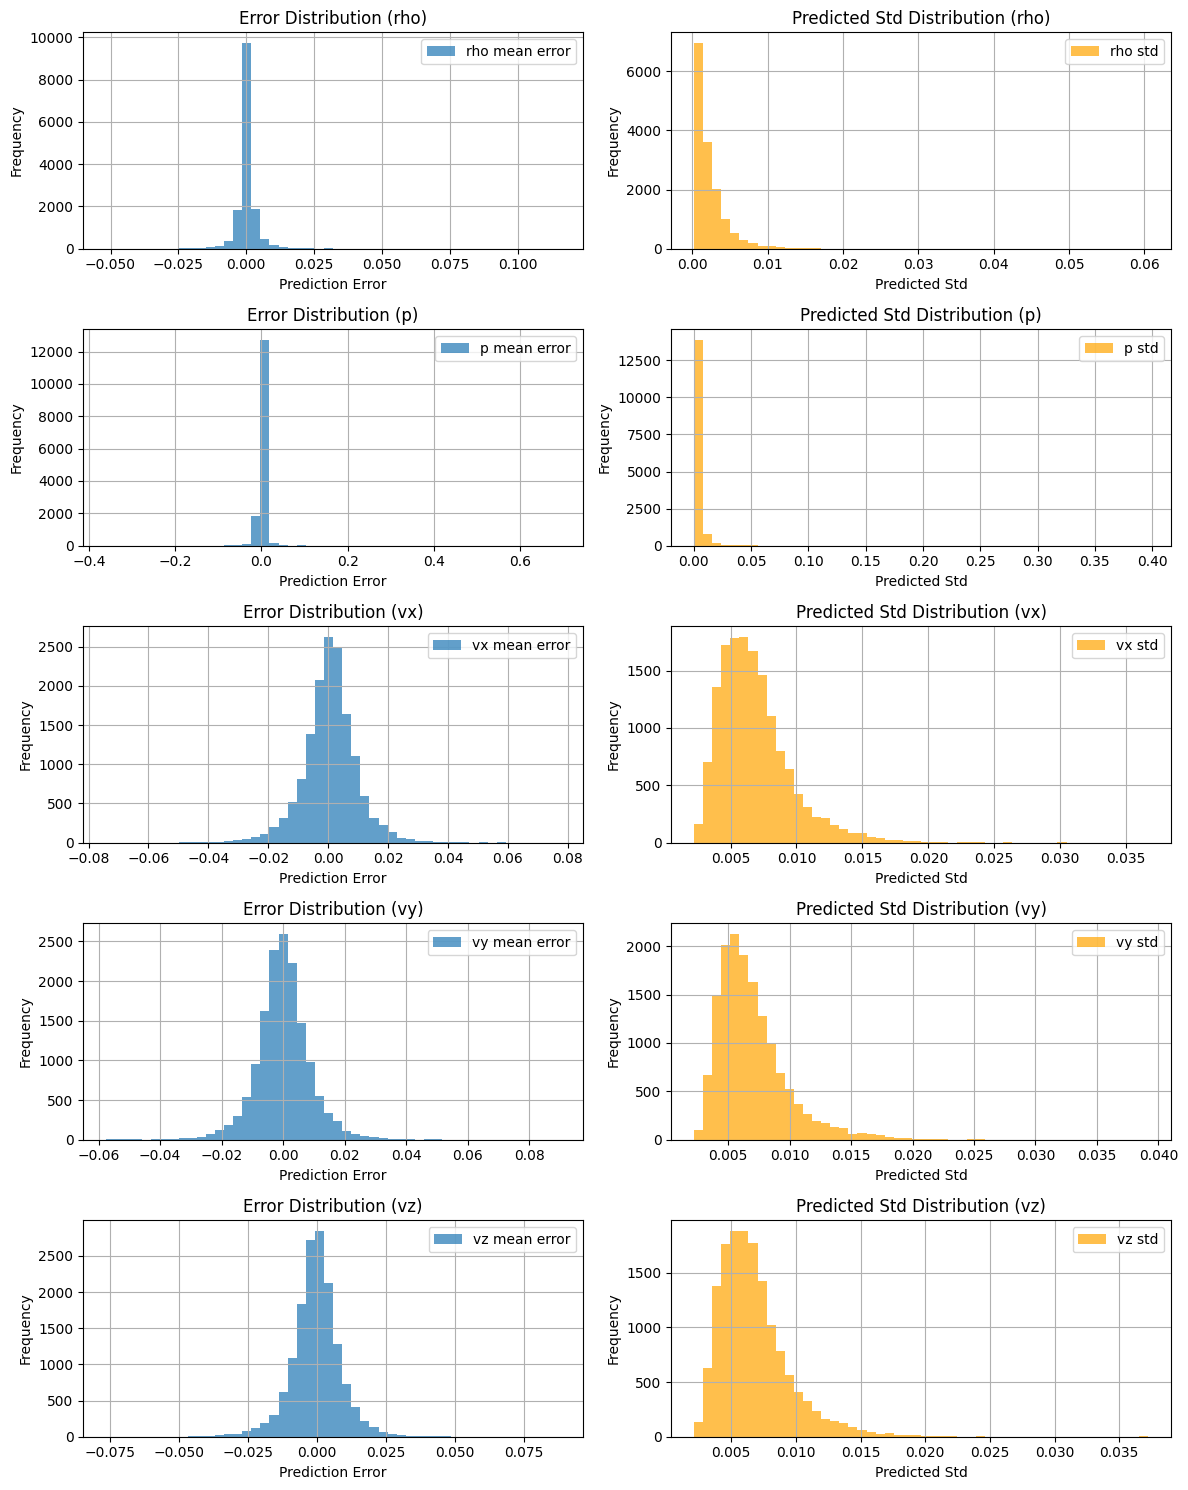

In [262]:

labels = ["rho", "p", "vx", "vy", "vz"]
indices = [0, 1, 2, 3, 4]
# Histogram grid: 5 rows, 2 cols
fig, axs = plt.subplots(5, 2, figsize=(12, 15))
for i, (label, idx) in enumerate(zip(labels, indices)):
    plot_hist_single(axs[i, 0], axs[i, 1], mean[:, idx].numpy(), val_prim[:,idx].numpy(), std[:, idx].numpy(), label)

plt.tight_layout()
plt.show()

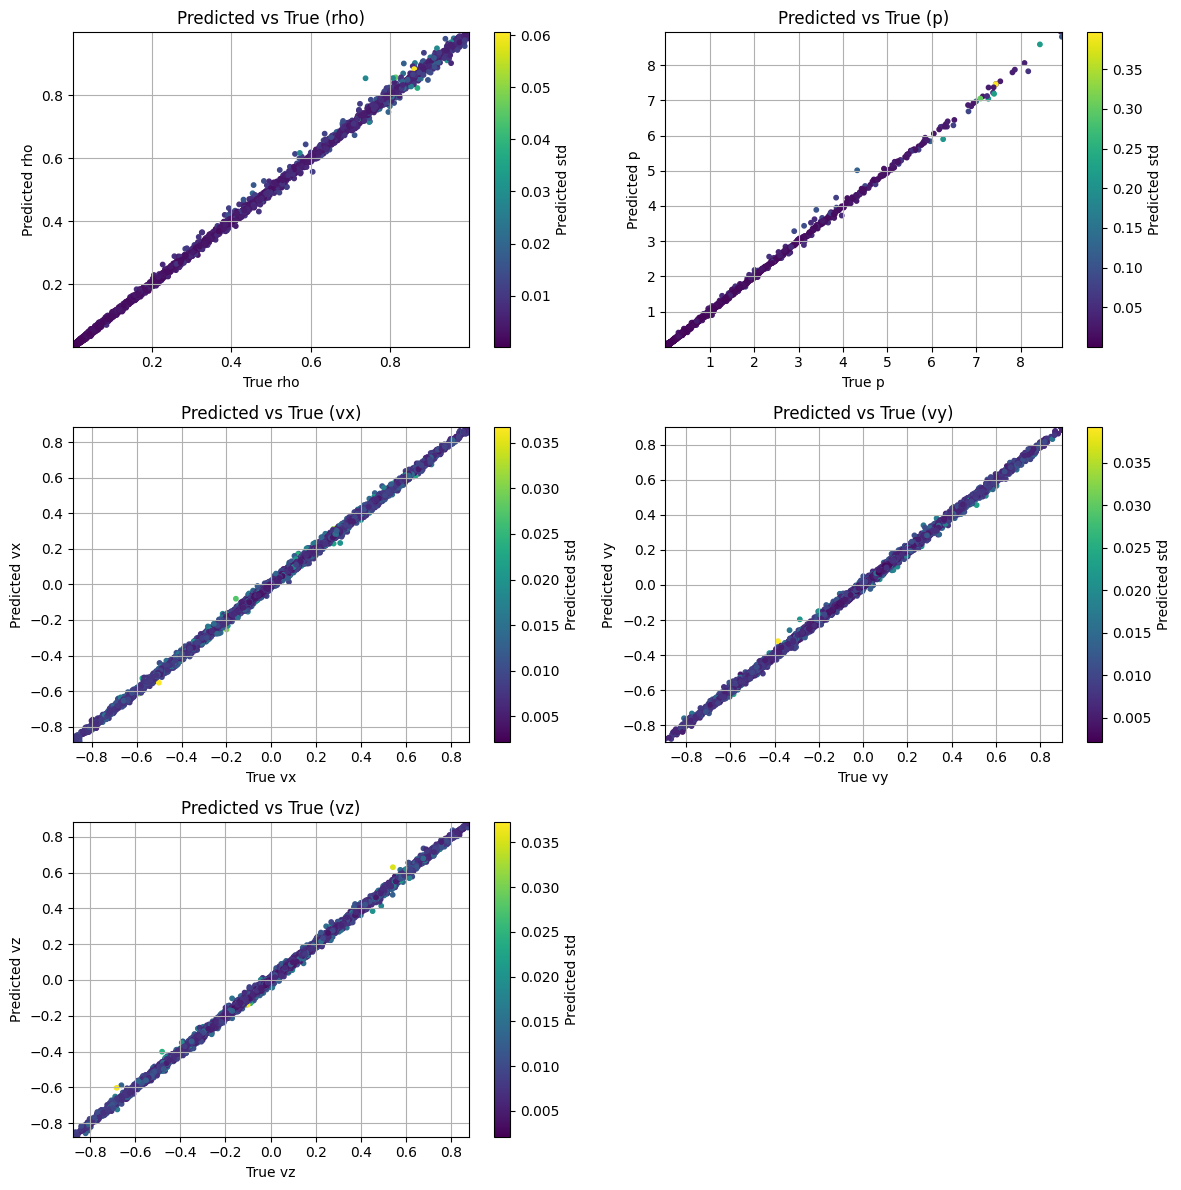

In [263]:

# Scatter grid: 3x2
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten()
labels = ["rho", "p", "vx", "vy", "vz"]
indices = [0, 1, 2, 3, 4]

for i, (label, idx) in enumerate(zip(labels, indices)):
    sc = plot_scatter_single(axs[i], val_prim[:, idx].numpy(), mean[:, idx].numpy(), std[:, idx].numpy(), label)
    plt.colorbar(sc, ax=axs[i], label="Predicted std")

for j in range(len(labels), len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

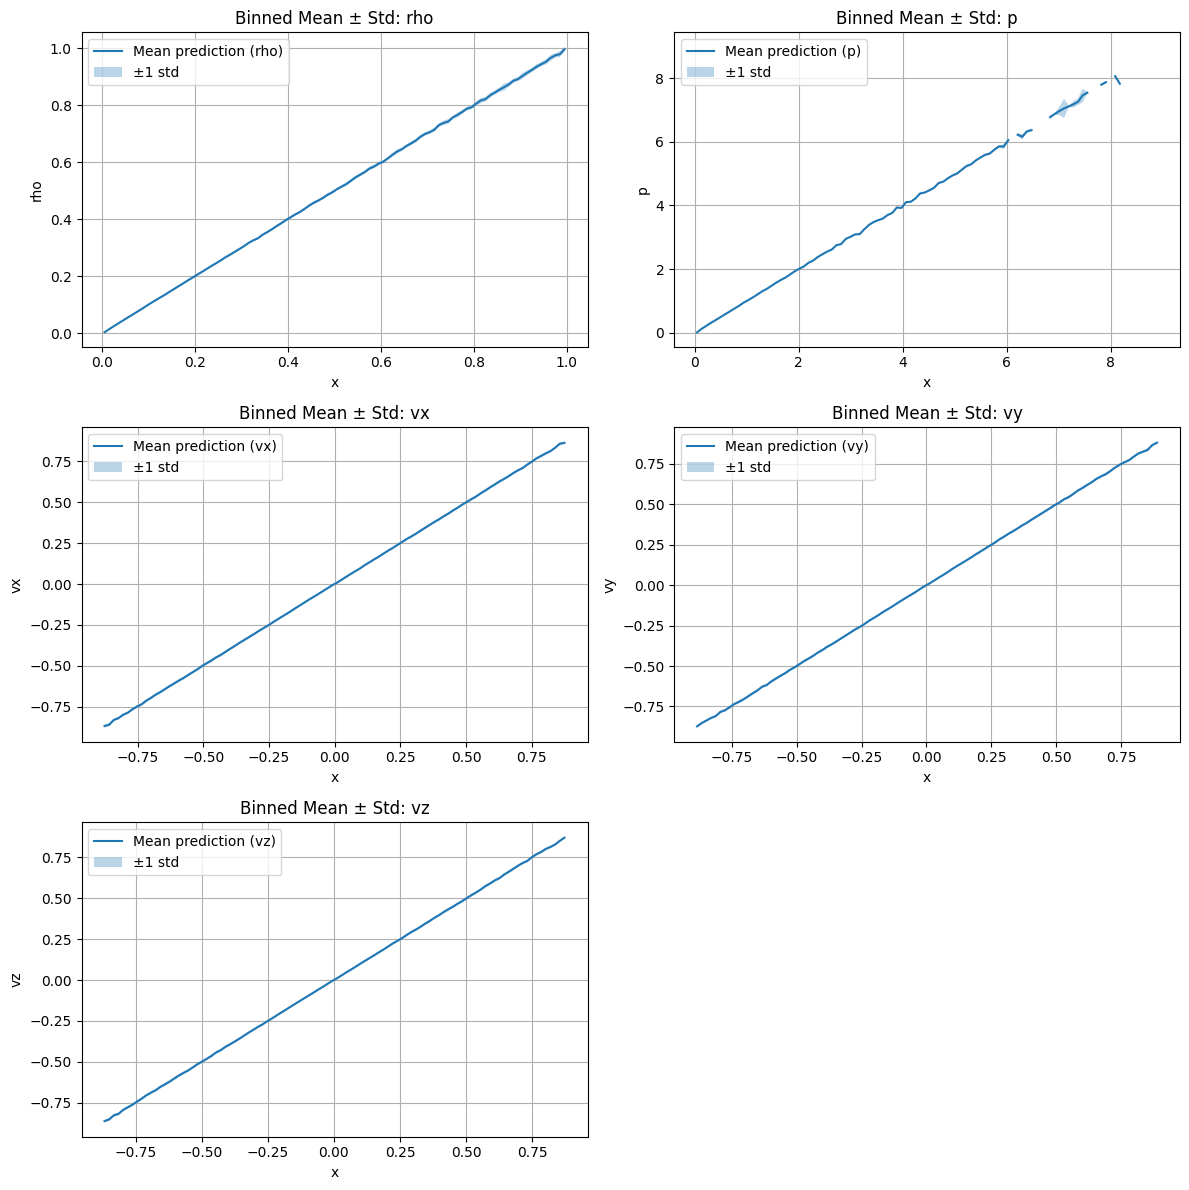

In [264]:
# 1D Slice Plot: 3x2 grid
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten()
labels = ["rho", "p", "vx", "vy", "vz"]
indices = [0, 1, 2, 3, 4]

for i, (label, idx) in enumerate(zip(labels, indices)):
    x = val_prim[:, idx].numpy()
    y = mean[:, idx].numpy()
    s = std[:, idx].numpy()

    plot_binned_uncertainty(
        axs[i],
        x,
        y,
        s,
        label=label
    )

# Hide unused subplot
for j in range(len(labels), len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

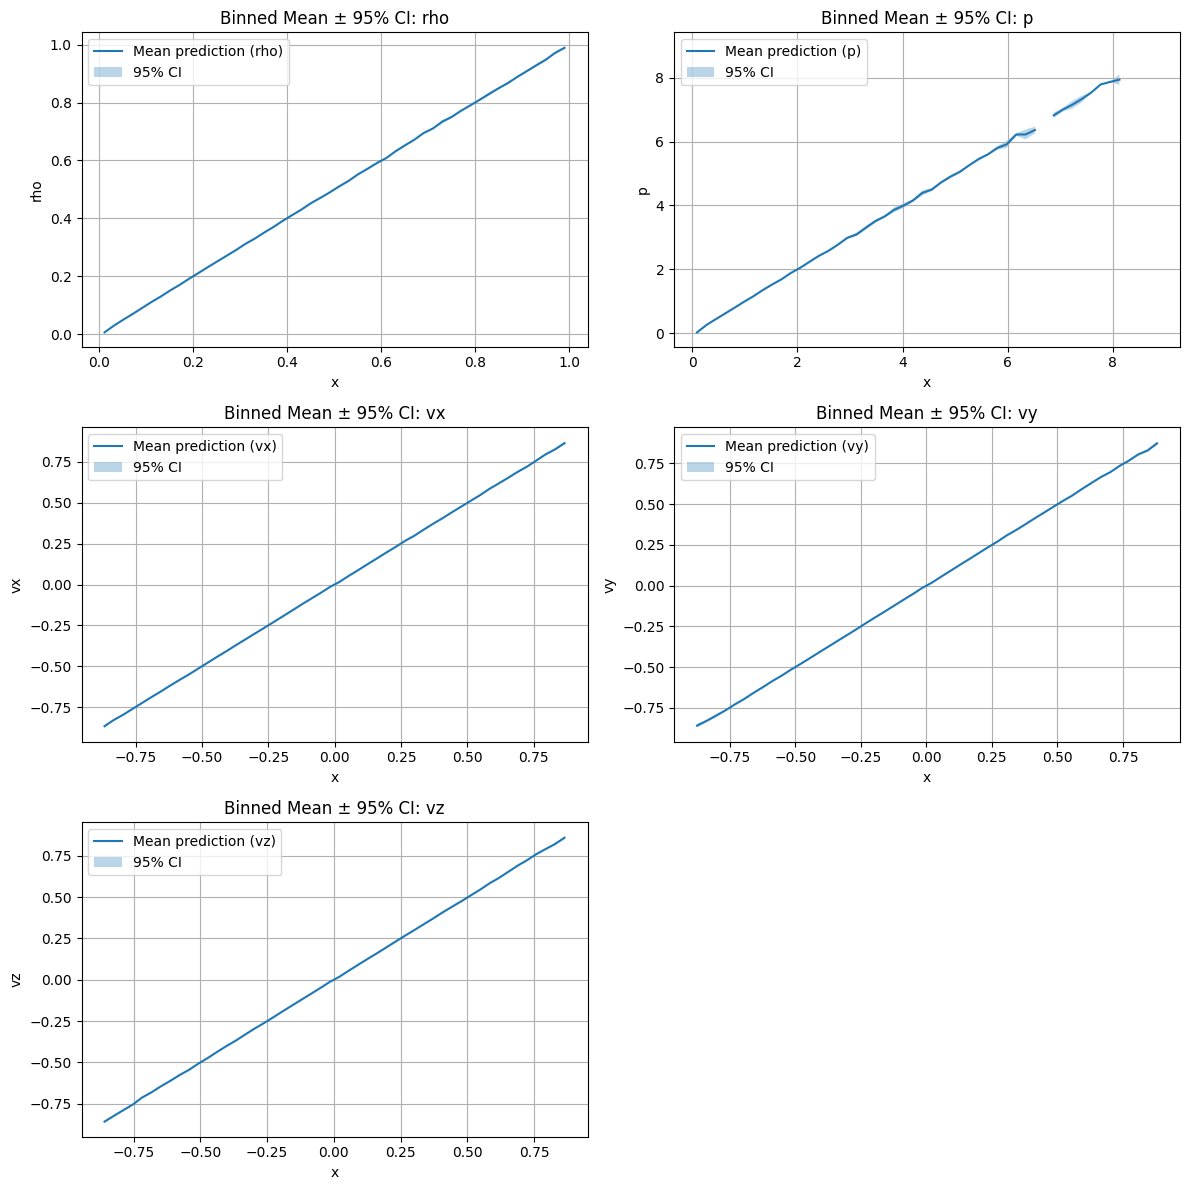

In [265]:
from scipy import stats  # Required for binned_statistic

# 1D Slice Plot: 3x2 grid
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten()
labels = ["rho", "p", "vx", "vy", "vz"]
indices = [0, 1, 2, 3, 4]

for i, (label, idx) in enumerate(zip(labels, indices)):
    x = val_prim[:, idx].numpy()
    y = mean[:, idx].numpy()
    plot_binned_confidence_interval(axs[i], x, y, label=label, xlabel="x", ylabel=label)

# Hide unused subplot
for j in range(len(labels), len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()



In [235]:
!pip install scipy